# Differential Event Rate

It is derived as the duration distribution of microlensing events:
\begin{equation}
\frac{d\Gamma_{\rm PBH}}{d\hat{t}} = 2 \frac{\Omega_{\rm PBH}}{\Omega_{\rm DM}} 
\int_0^{d_s} dd_L \int_0^{u_T(d_L, M_{\rm PBH})} du_{\min} \,
\frac{1}{\sqrt{u_T^2(d_L, M_{\rm PBH}) - u_{\min}^2}}  \,
\frac{\rho_{\rm DM}(d_L)}{M_{\rm PBH} v_c^2(d_L)} \, 
v^4 \exp\left[-\frac{v^2}{v_c^2(d_L)}\right],
\end{equation}
$\quad \text{donde} \quad v = \frac{2 R_E \sqrt{u_T^2 - u_{\min}^2}}{\hat{t}}$.


The profile describing the halo objects of the galaxy will be given by Navarro Frenk and White:
\begin{equation}
    \rho_{NFW}(R) =  \frac{\rho_{c}}{(\frac{r}{r_s})(\frac{r}{r_s}+1)^2} \,,
\end{equation}
with $\rho_{\odot} = 0.0097M_{\odot}\text{pc}^{-3}$, $R_C= 5$ kpc as the core radius of the galaxy, and $R_{Sol}=8.5$ kpc as the distance from the Sun to the center of the galaxy.

On the other hand, $v_E = R_E(x)/t_E$.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as C
import scipy.integrate as integrate
from scipy.integrate import simpson, dblquad
from event_rate import dif_event_rate, integrand_jax, integrand_jax_m31, double_integral_2d
from tqdm import tqdm
import time
import os
import jax
import jax.numpy as jnp
from jax import vmap
from jax.scipy.integrate import trapezoid

os.environ["JAX_PLATFORM_NAME"] = "gpu"
print("Plataforma por defecto:", jax.default_backend())
print("Dispositivos disponibles:", jax.devices())
jax.config.update("jax_enable_x64", True)

2025-04-12 15:48:03.571585: E external/xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


RuntimeError: Unable to initialize backend 'cuda': FAILED_PRECONDITION: No visible GPU devices. (you may need to uninstall the failing plugin package, or set JAX_PLATFORMS=cpu to skip this backend.)

In [2]:
rho_c_MW = 4.88e6*C.M_sun/u.kpc**3
rs_MW = 21.5*u.kpc
rho_c_M31 = 4.96e6*C.M_sun/u.kpc**3
rs_M31 = 25*u.kpc
uT = 1
l,b = 121.2, -21.6 
D = 770*u.kpc
# m = 10**-7*u.M_sun
t=1*u.hour

masses = np.logspace(-12,-7,12-7+1)*u.M_sun
m = masses[-1]

In [3]:
# integrar sin jax
not_jax = False
if not_jax:
    d2gamadt2_MW = []
    d2gamadt2_M31 = []
    for t in tqdm(t_hat):
        d2gamadt2_MW.append(dif_event_rate( t, m, D, rs_MW, rho_c_MW, l, b, uT).event_rate())
        d2gamadt2_M31.append(dif_event_rate( t, m, D, rs_M31, rho_c_M31, l, b, uT).event_rate())
    
    
    plt.figure(figsize=(8,6))
    plt.plot(t_hat,(np.array(d2gamadt2_MW)+np.array(d2gamadt2_M31)),lw=2, ls='-',color='r',label=str(m.value)+r'$M_{\odot}$')
    plt.plot(t_hat,np.array(d2gamadt2_MW), alpha=0.5,lw=2, ls='--',color='b')
    plt.plot(t_hat,np.array(d2gamadt2_M31), alpha=0.5,lw=2, ls='--',color='g')
    plt.xscale("log")
    plt.yscale("log")
    plt.ylim(1e-8,1e-2)
    
    plt.ylabel(r'$\frac{d\Gamma}{dt_E}(events/hour/hour)$',fontsize=15)
    plt.xlabel(r'$t_E [days]$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(loc='best' ,fontsize=15)


In [4]:
# double_integral_2d_jit = jax.jit(double_integral_2d, static_argnames=["f"])

In [4]:
f_jax = lambda u, x: integrand_jax_m31(u, x, D=D.to('m').value, rs=rs_MW.to('m').value, rho_c=rho_c_MW.to('kg/m^3').value,
                                   t=float(t.to('s').value), m=m.to('kg').value, l_coord=l,
                                   b_coord=b, uT=uT)

t0 = time.time()
event_rate_data = dif_event_rate( t, m, D, rs_MW, rho_c_MW, l, b, uT, False)
print('resultado integrando',event_rate_data.integrand(0.5,0.5))
print('resultado integral usando dbquad',event_rate_data.event_rate())
tf = time.time()
print('Tiempo transcurrido integrando con dbquad',tf-t0)
print('   ')
t0 = time.time()
resultado_jax = double_integral_2d(f_jax, (0.0, uT-1e-15), (0.0, 1.0-1e-9))
print('resultado integrando usando JAX',integrand_jax_m31(0.5, 0.5, D.to('m').value, rs_MW.to('m').value, rho_c_MW.to('kg/m^3').value, float(t.to('s').value), m.to('kg').value, l, b, uT))
print('resultado integral usando JAX',resultado_jax)
tf = time.time()
print('Tiempo transcurrido integrando con JAX',tf-t0)


resultado integrando 8.956820816943451e-32
resultado integral usando dbquad 3.45288282217943e-07
Tiempo transcurrido integrando con dbquad 2.1643283367156982
   
resultado integrando usando JAX 8.956820816943577e-32
resultado integral usando JAX 3.454676912048562e-07
Tiempo transcurrido integrando con JAX 4.045384168624878


In [5]:
f_jax = lambda u, x: integrand_jax(u, x, D=D.to('m').value, rs=rs_MW.to('m').value, rho_c=rho_c_MW.to('kg/m^3').value,
                                   t=float(t.to('s').value), m=m.to('kg').value, l_coord=l,
                                   b_coord=b, uT=uT)
t0 = time.time()
event_rate_data = dif_event_rate( t, m, D, rs_MW, rho_c_MW, l, b, uT, True)
print('resultado integrando',event_rate_data.integrand(0.5,0.5))
print('resultado integral usando dbquad',event_rate_data.event_rate())
tf = time.time()
print('Tiempo transcurrido integrando con dbquad',tf-t0)
print('   ')
t0 = time.time()
resultado_jax = double_integral_2d(f_jax, (0.0, uT-1e-15), (0.0, 1.0))
print('resultado integrando usando JAX',integrand_jax(0.5, 0.5, D.to('m').value, rs_MW.to('m').value, rho_c_MW.to('kg/m^3').value, float(t.to('s').value), m.to('kg').value, l, b, uT))
print('resultado integral usando JAX',resultado_jax)
tf = time.time()
print('Tiempo transcurrido integrando con JAX',tf-t0)


resultado integrando 6.119038840901917e-32
resultado integral usando dbquad 1.388623456166031e-07
Tiempo transcurrido integrando con dbquad 5.893287181854248
   
resultado integrando usando JAX 6.119038840902131e-32
resultado integral usando JAX 1.3885964528176913e-07
Tiempo transcurrido integrando con JAX 0.5934081077575684


/home/anibal-pc/Lentes_gravitacionales/event_rate.py:110: RuntimeWarning: divide by zero encountered in divide
  return (2*f*u.hour*u.hour*self.D*(1/u_factor)*rho*exp_fac*Q*vr**2  /self.m ).decompose()
/home/anibal-pc/anaconda3/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


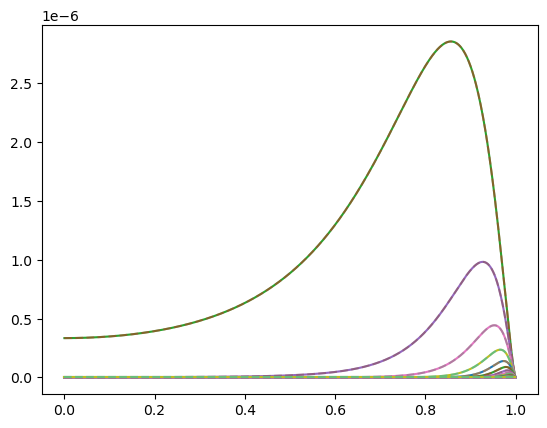

/home/anibal-pc/Lentes_gravitacionales/event_rate.py:186: RuntimeWarning: divide by zero encountered in scalar divide
  rho = rho_c / (c * (1 + c)**2)


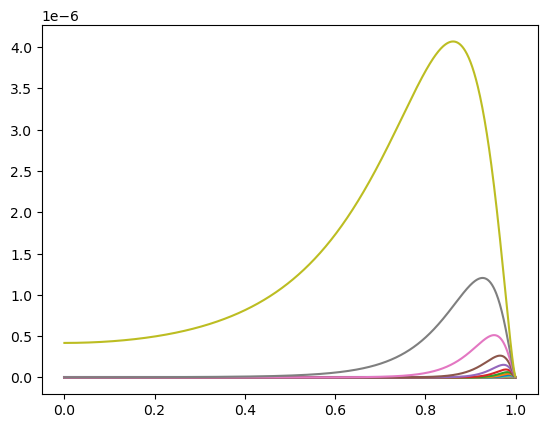

In [6]:
#comparacion integrandos
umin = np.linspace(0,1,1000)
X = np.linspace(0,1,30)
for x in X:
    plt.plot(umin,integrand_jax(umin, x, D.to('m').value, rs_MW.to('m').value, rho_c_MW.to('kg/m^3').value, float(t.to('s').value), m.to('kg').value, l, b, uT))
    plt.plot(umin, event_rate_data.integrand(x,umin),'--',alpha=0.5)
plt.show()

for x in X:
    plt.plot(umin,integrand_jax_m31(umin, x, D.to('m').value, rs_MW.to('m').value, rho_c_MW.to('kg/m^3').value, float(t.to('s').value), m.to('kg').value, l, b, uT))



In [24]:
# str(m)


In [28]:
# Convertís tus cantidades antes:
# m_val = m.to('kg').value
expmin = -12
expmax=-5
# expmin-expmax+1
masses = np.logspace(expmin,expmax,10)*u.M_sun
t_hat = np.logspace(-1, 0.7, 200)*u.hour.to('s')

rs_MW_val = rs_MW.to('m').value
rho_c_MW_val = rho_c_MW.to('kg/m^3').value

rs_M31_val = rs_M31.to('m').value
rho_c_M31_val = rho_c_M31.to('kg/m^3').value

D_val = D.to('m').value

l_val = l
b_val = b
uT_val = uT
# Definís la función con los parámetros fijos
d2gamadt2_MW = {str(m):[] for m in masses}
d2gamadt2_M31 = {str(m):[] for m in masses}
d2event_rate = {str(m):[] for m in masses}
for m in tqdm(masses): 
    m_val = m.to('kg').value

    for t_val in t_hat:
        f_jax_MW = lambda u, x: integrand_jax(u, x, D=D_val, rs=rs_MW_val, rho_c=rho_c_MW_val,
                                           t=t_val, m=m_val, l_coord=l,
                                           b_coord=b, uT=uT_val)
        
        # Definís la función con los parámetros fijos
        f_jax_M31 = lambda u, x: integrand_jax_m31(u, x, D=D_val, rs=rs_M31_val, rho_c=rho_c_M31_val,
                                           t=t_val, m=m_val, l_coord=l,
                                           b_coord=b, uT=uT_val)
        
        resultado_MW = double_integral_2d(f_jax_MW, (0.0, uT-1e-15), (0.0, 1.0))
        resultado_M31 = double_integral_2d(f_jax_M31, (0.0, uT-1e-15), (0.0, 1.0-1e-9))
        
        d2gamadt2_MW[str(m)].append(resultado_MW)
        d2gamadt2_M31[str(m)].append(resultado_M31)
        # d2event_rate[str(m)].append(np.array(resultado_MW)+np.array(resultado_M31))
        


100%|███████████████████████████████████████████| 10/10 [02:00<00:00, 12.09s/it]


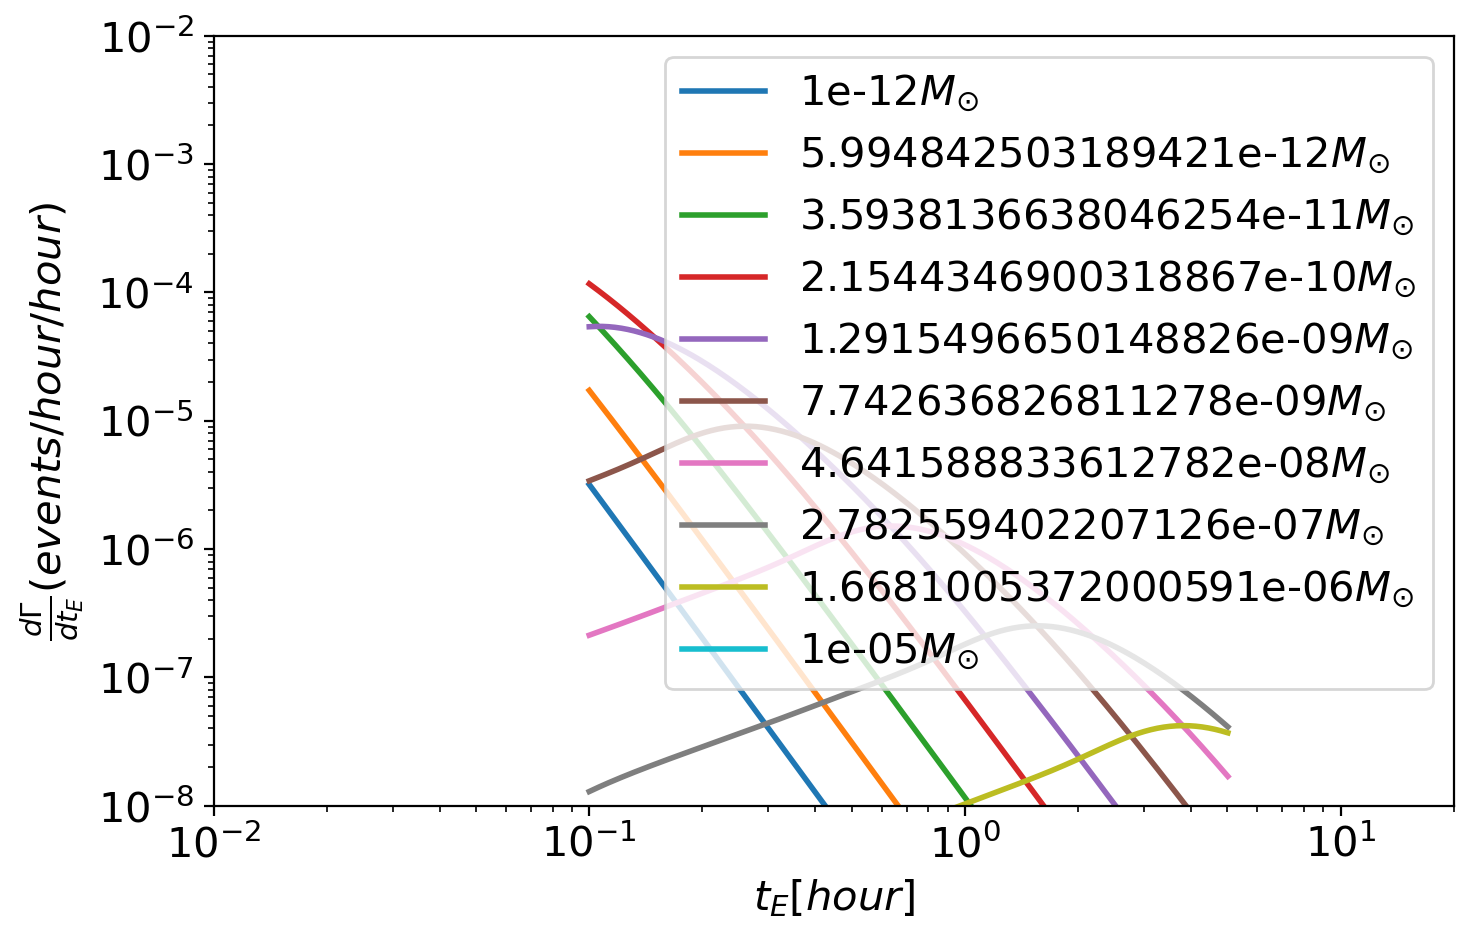

In [29]:
#niikura plots
plt.figure(figsize=(8,5),dpi=200)
for m in masses: 
    plt.plot(t_hat/3600,(np.array(d2gamadt2_MW[str(m)])+np.array(d2gamadt2_M31[str(m)])),lw=2, marker='',ls='-',label=str(m.value)+r'$M_{\odot}$')
# plt.plot(t_hat/3600,np.array(d2gamadt2_MW[str(m)]), alpha=0.5,lw=2, ls='--',color='b')
# plt.plot(t_hat/3600,np.array(d2gamadt2_M31[str(m)]), alpha=0.5,lw=2, ls='--',color='g')
plt.xscale("log")
plt.yscale("log")
plt.ylim(1e-8,1e-2)
plt.xlim(1e-2,2e1)

plt.ylabel(r'$\frac{d\Gamma}{dt_E}(events/hour/hour)$',fontsize=15)
plt.xlabel(r'$t_E [hour]$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='best' ,fontsize=15)
plt.savefig('/home/anibal-pc/figures_final_makler/rates_niikura.png')
plt.show()

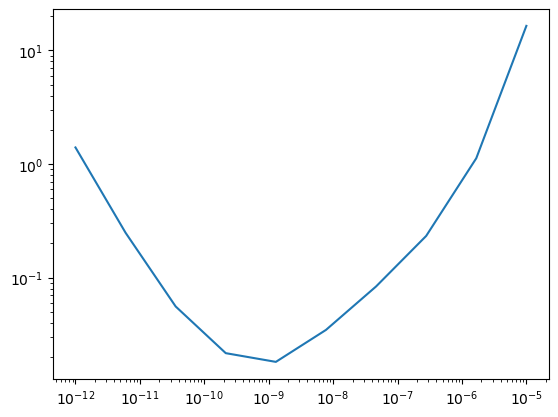

In [40]:
from scipy.integrate import simpson
Nexp = []
for m in masses:
    Nexp.append(simpson(np.array(d2gamadt2_MW[str(m)])+np.array(d2gamadt2_M31[str(m)]),x=t_hat/3600))

# plt.loglog(masses, Nexp)
plt.loglog(masses, 3/(4e+7*0.5*np.array(Nexp)))

In [41]:
def double_integral_2d_variable_uT(f, x_vals, uT_vals, num_u=10000):
    """
    f: function f(u, x)
    x_vals: array of x values
    uT_vals: array of upper limits for u, one per x
    num_u: number of u sampling points per x
    """
    def inner_integral(x_val, uT_val):
        # u_vals = jnp.linspace(0, uT_val, num_u)
        # u_vals = jnp.linspace(0, jnp.maximum(uT_val, 1e-10), num_u)
        epsilon = 1e-3  # pequeño valor para evitar singularidades
        u_max_eff = jnp.maximum(uT_val - epsilon, 0.0)
        u_vals = jnp.linspace(0.0, u_max_eff, num_u)
        f_vals = vmap(lambda u: f(u, x_val))(u_vals)
        return trapezoid(f_vals, u_vals)

    # Vectorized over x_vals and corresponding uT_vals
    inner_vals = vmap(inner_integral)(x_vals, uT_vals)
    result = trapezoid(inner_vals, x_vals)
    return result


In [12]:
# np.sort(np.logspace(-15,5,100))[15]

In [13]:
# for i in range(100):
    # print(os.listdir('/home/anibal-pc/figures_final_makler/uT_curves/')[i])

In [42]:
import os
arr = []


for i in range(100):
    string = os.listdir('/home/anibal-pc/figures_final_makler/uT_curves/')[i]
    ini = string.index('1e-')+3
    fin = string.index('_NOT')

    # if 10**float(string[ini:fin]) == np.sort(np.logspace(-15,5,100))[15]:
    
    arr0 = np.load('/home/anibal-pc/figures_final_makler/uT_curves/'+string)['arr_0']
    arr1 = np.load('/home/anibal-pc/figures_final_makler/uT_curves/'+string)['arr_1']

    # print(string)
    arr.append(10**float(string[ini:fin]))
    # plt.plot(arr1[:len(arr0)],arr0, label=str(10**float(string[ini:fin])))
    # print(min(arr0))
    # plt.xscale("log")
    # break
# plt.legend(loc=(1.1,0),ncols=5)
# plt.show()
# print(arr)
# print(np.sort(np.array(arr))==np.logspace(-15,-5,100))

In [43]:
for i in range(2,5):
    string = os.listdir('/home/anibal-pc/figures_final_makler/uT_curves/')[i]
    ini = string.index('1e-')+3
    fin = string.index('_NOT')

    # if 10**float(string[ini:fin]) == np.sort(np.logspace(-15,5,100))[15]:
    
    arr0 = np.load('/home/anibal-pc/figures_final_makler/uT_curves/'+string)['arr_0']
    arr1 = np.load('/home/anibal-pc/figures_final_makler/uT_curves/'+string)['arr_1']
    
        # print(string)
        # arr.append(10**float(string[ini:fin]))
        # plt.plot(arr1[:len(arr0)],arr0, label=str(10**float(string[ini:fin])))
        # print(min(arr0))
        # plt.xscale("log")
        # break
    print(string[ini:fin])
    print(string)
    m = 10**float(string[ini:fin]) * u.M_sun
    print(str(m))
    

-14.8989898989899
uT_1e--14.8989898989899_NOT_LD.npz
1.2618568830660185e-15 solMass
-6.4141414141414135
uT_1e--6.4141414141414135_NOT_LD.npz
3.853528593710535e-07 solMass
-10.353535353535353
uT_1e--10.353535353535353_NOT_LD.npz
4.430621457583887e-11 solMass


In [18]:
# 10**(-3.98)

In [45]:
# string = os.listdir('/home/anibal-pc/figures_final_makler/uT_curves/')[0]
# ini = string.index('1e-')+3
# fin = string.index('_NOT')

# arr0 = np.load('/home/anibal-pc/figures_final_makler/uT_curves/'+string)['arr_0']
# arr1 = np.load('/home/anibal-pc/figures_final_makler/uT_curves/'+string)['arr_1']
# plt.plot(arr1,arr0)
# plt.plot(jnp.linspace(0,1),jnp.interp(jnp.linspace(0,1), arr1, arr0))
# plt.xscale("log")
# plt.yscale("log")

In [48]:
# import numpy as np
# import jax.numpy as jnp
# import matplotlib.pyplot as plt

# # Cargar arrays
# data = np.load('/home/anibal-pc/figures_final_makler/uT_curves/' + string)
# arr0 = data['arr_0']
# arr1 = data['arr_1']

# # Interpolación y graficado
# x_interp = jnp.logspace(-6, 0, 200)
# y_interp = jnp.interp(x_interp, arr1, arr0)

# plt.plot(arr1, arr0, label='Datos originales')
# plt.plot(x_interp, y_interp, '--', label='Interpolación')
# plt.xscale("log")
# plt.legend()
# plt.show()


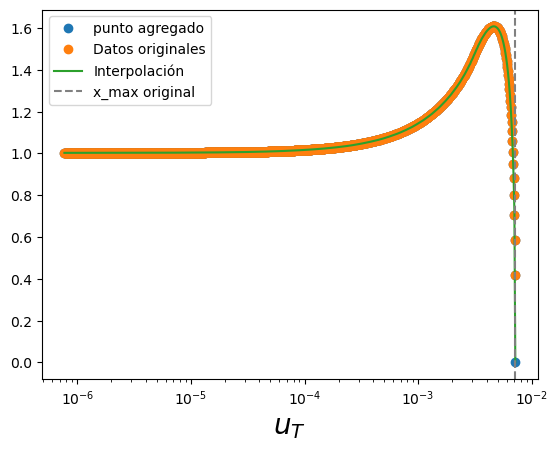

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Cargar datos
data = np.load('/home/anibal-pc/figures_final_makler/uT_curves/' + string)
arr0 = data['arr_0']
arr1 = data['arr_1']

# Asegurar orden creciente
sorted_indices = np.argsort(arr1)
arr1 = arr1[sorted_indices]
arr0 = arr0[sorted_indices]

# Agregar un punto artificial que decae a 0
x_max = arr1[-1]
delta = 0.001 * x_max  # un pequeño paso más allá
arr1_extended = np.append(arr1, x_max + delta)
arr0_extended = np.append(arr0, 0.0)

# Interpolador cúbico o lineal (según prefieras)
interp_func = interp1d(arr1_extended, arr0_extended, kind='cubic', bounds_error=False, fill_value=0.0)

# Interpolación
x_interp = np.logspace(np.log10(arr1[0]), np.log10(x_max + delta), 500)
y_interp = interp_func(x_interp)

# Plot
plt.plot(arr1_extended, arr0_extended, 'o', label='punto agregado')
plt.plot(arr1, arr0, 'o', label='Datos originales')
plt.plot(x_interp, y_interp, '-', label='Interpolación')

plt.axvline(x_max, color='gray', linestyle='--', label='x_max original')
plt.xlabel("x",fontsize=20)
plt.xlabel(r"$u_T$",fontsize=20)
plt.xscale('log')
plt.legend()
plt.show()

In [ ]:
from jax import numpy as jnp, vmap
from tqdm import tqdm
d2gamadt2_MW = {}
d2gamadt2_M31 = {}
d2event_rate = {}

# Función de interpolación compatible con JAX
def f_jax_factory(integrand_jax_fn, D_val, rs_val, rho_c_val, t_val, m_val, l_val, b_val, x_vals, uT_vals):
    def f_jax(u, x):
        x_clipped = jnp.clip(x, x_vals[0], x_vals[-1])
        uT_x = jnp.interp(x_clipped, x_vals, uT_vals)
        # uT_x = jnp.interp(x, x_vals, uT_vals)
        return integrand_jax_fn(u, x, D=D_val, rs=rs_val, rho_c=rho_c_val,
                                t=t_val, m=m_val, l_coord=l_val, b_coord=b_val,
                                uT=uT_x)
    return f_jax


for i in tqdm(range(1)):
    string = os.listdir('/home/anibal-pc/figures_final_makler/uT_curves/')[i]
    ini = string.index('1e-')+3
    fin = string.index('_NOT')
    
    arr0 = np.load('/home/anibal-pc/figures_final_makler/uT_curves/'+string)['arr_0']
    arr1 = np.load('/home/anibal-pc/figures_final_makler/uT_curves/'+string)['arr_1']
    plt.plot(arr1,arr0)
    plt.plot(jnp.logspace(-5,0),jnp.interp(jnp.logspace(-5,0), arr1, arr0))
    plt.xscale("log")

    m = 10**float(string[ini:fin]) * u.M_sun
    # print(str(m))
    
    # Loop principal
    t_hat = np.logspace(-3, 2, 100) * u.hour.to('s')
    
    rs_MW_val = rs_MW.to('m').value
    rho_c_MW_val = rho_c_MW.to('kg/m^3').value
    rs_M31_val = rs_M31.to('m').value
    rho_c_M31_val = rho_c_M31.to('kg/m^3').value
    D_val = D.to('m').value
    l_val = l
    b_val = b
    
    # Masa y preparación de resultados
    # m = 10**float(string[ini:fin]) * u.M_sun
    # print(str(m))
    m_val = m.to('kg').value
    d2gamadt2_MW[str(m)] = []
    d2gamadt2_M31[str(m)] = []
    d2event_rate[str(m)] = []
    # Variables fijas en x (x_vals = distancia normalizada), uT_vals = límites superiores variables
    print('x',max(arr1),min(arr1))
    print('uT',max(arr0),min(arr0))
    # if len(arr1)==len(arr0):
    #     x_vals = arr1
    #     uT_vals = arr0
    # elif not len(arr1)==len(arr0):
    #     x_vals = arr1
    #     uT_vals = arr0[:len(arr1)]
    
    x_vals = np.logspace(-9,-2)
    # uT_vals = np.logspace(-0.37,0.20,50)
    uT_vals = np.logspace(-3,-2,50)
    
    # # Loop temporal
    for t_val in t_hat:
        
        # Creamos funciones del integrando con interpolación jax
        f_jax_MW = f_jax_factory(integrand_jax, D_val, rs_MW_val, rho_c_MW_val, t_val, m_val, l_val, b_val, x_vals, uT_vals)
        f_jax_M31 = f_jax_factory(integrand_jax_m31, D_val, rs_M31_val, rho_c_M31_val, t_val, m_val, l_val, b_val, x_vals, uT_vals)
    
        # Ejecutamos la integración
        resultado_MW = double_integral_2d_variable_uT(f_jax_MW, uT_vals, x_vals)
        resultado_M31 = double_integral_2d_variable_uT(f_jax_M31, uT_vals, x_vals)
    
        # Guardamos resultados
        d2gamadt2_MW[str(m)].append(resultado_MW)
        d2gamadt2_M31[str(m)].append(resultado_M31)
        d2event_rate[str(m)].append(resultado_MW + resultado_M31)


  0%|                                                     | 0/1 [00:00<?, ?it/s]

In [66]:
# print(0.007157626156255947, 7.7e-07)
# print(1.6080675481745537, 0.41770251319343976)


In [67]:
# np.log10(0.007157626156255947)

In [91]:
d2event_rate

{'6.428073117284319e-15 solMass': [Array(2.25607792e-11, dtype=float64),
  Array(1.41688608e-11, dtype=float64),
  Array(8.89847437e-12, dtype=float64),
  Array(5.58850964e-12, dtype=float64),
  Array(3.50975111e-12, dtype=float64),
  Array(2.20422806e-12, dtype=float64),
  Array(1.3843205e-12, dtype=float64),
  Array(8.69394134e-13, dtype=float64),
  Array(5.4600511e-13, dtype=float64),
  Array(3.4290725e-13, dtype=float64),
  Array(2.1535581e-13, dtype=float64),
  Array(1.35249757e-13, dtype=float64),
  Array(8.49408047e-14, dtype=float64),
  Array(5.33453087e-14, dtype=float64),
  Array(3.35024125e-14, dtype=float64),
  Array(2.10404934e-14, dtype=float64),
  Array(1.3214044e-14, dtype=float64),
  Array(8.29880523e-15, dtype=float64),
  Array(5.21189179e-15, dtype=float64),
  Array(3.27322006e-15, dtype=float64),
  Array(2.05567765e-15, dtype=float64),
  Array(1.29102551e-15, dtype=float64),
  Array(8.10801658e-16, dtype=float64),
  Array(5.09207079e-16, dtype=float64),
  Array(3.19

In [55]:

for key in tqdm(d2event_rate):
    dgamadt = np.array([float(f) for f in d2event_rate[key]])
    np.savez('/home/anibal-pc/figures_final_makler/dgama_dt/rate_'+key, dgamadt, t_hat)

100%|███████████████████████████████████████| 100/100 [00:00<00:00, 2514.27it/s]


In [60]:

np.array([float(f) for f in d2event_rate[key]])

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [57]:
# plt.loglog(t_hat/3600,d2event_rate['6.428073117284319e-15 solMass'])
plt.figure(figsize=(8,5),dpi=200)
# for key in tqdm(d2event_rate):
key = '1.9179102616724847e-07 solMass'
plt.plot(t_hat/3600,np.array([float(f) for f in d2event_rate[key]]))
plt.xscale("log")
plt.yscale("log")
# plt.ylim(1e-8,1e-2)
plt.xlim(1e-2,2e1)

plt.ylabel(r'$\frac{d\Gamma}{dt_E}(events/hour/hour)$',fontsize=15)
plt.xlabel(r'$t_E [hour]$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='best' ,fontsize=15)
plt.savefig('/home/anibal-pc/figures_final_makler/rates_niikura_fs.png')
plt.show()

ValueError: Data has no positive values, and therefore cannot be log-scaled.

Error in callback <function _draw_all_if_interactive at 0x70f7f4ecbba0> (for post_execute), with arguments args (),kwargs {}:


ValueError: Data has no positive values, and therefore cannot be log-scaled.

ValueError: Data has no positive values, and therefore cannot be log-scaled.

<Figure size 1600x1000 with 1 Axes>

In [40]:
# t_hat = np.logspace(-10, 4,100)
# M     = np.logspace(-10,10,100)

# N = []
# rates_int = np.zeros([len(t_hat),len(M)])
# for j in tqdm(range(len(M))):
#     for i in range(len(t_hat)):
#         if t_hat[i]<1e-2:
#             rates_int[i,j] = 0
#         elif t_hat[i]>400:
#             rates_int[i,j] = 0
#         else:
#             rates_int[i,j] = event_rate(t_hat[i],M[j])
#     Nexp = simps(rates_int[:,j], t_hat)
#     N.append(Nexp)
# N = np.array(N)